In [1]:
# ===== 環境設定 =====
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Part_4 本地化路徑設定
NOTEBOOK_DIR = Path.cwd()
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

RESULTS_DIR = OUTPUT_DIR / 'P4_Unit16_Results'
RESULTS_DIR.mkdir(exist_ok=True)

# NEU-DET 數據集路徑（Part_4 本地數據）
NEU_DET_DIR = NOTEBOOK_DIR / 'data' / 'NEU-DET'

print('Notebook 目錄:', NOTEBOOK_DIR)
print('輸出目錄:', OUTPUT_DIR)
print('結果目錄:', RESULTS_DIR)
print('NEU-DET 數據集:', NEU_DET_DIR)

# 設定 Matplotlib 中文字體
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
print("✓ Matplotlib 中文字體已設定")

Notebook 目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4
輸出目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs
結果目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_Results
NEU-DET 數據集: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\NEU-DET
✓ Matplotlib 中文字體已設定


---
## 第 1 章：數據集探索

在訓練模型之前，必須先了解數據集的特性：
- 每種缺陷的數量是否平衡？
- 影像的視覺特徵是什麼？
- 不同缺陷之間是否容易混淆？

In [2]:
# ===== 載入 NEU-DET 數據集 =====
from sklearn.model_selection import train_test_split

# 定義缺陷類別（中英對照）
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
class_names_zh = ['龜裂', '雜質', '斑塊', '麻點', '氧化皮', '劃痕']
class_to_zh = dict(zip(class_names, class_names_zh))

# 準備路徑
train_dir = NEU_DET_DIR / 'train' / 'images'
val_dir = NEU_DET_DIR / 'validation' / 'images'

# 檢查數據集是否存在
if not train_dir.exists():
    print(f"❌ 找不到數據集：{train_dir}")
    print("請確保 NEU-DET 數據集位於 Part_4/data/NEU-DET/ 目錄下")
    print("下載連結: https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database")
else:
    print("✓ 數據集路徑正確")
    
    # 統計每個類別的影像數量
    print("\n【數據集統計】")
    print("=" * 60)
    
    train_counts = {}
    val_counts = {}
    
    for class_name in class_names:
        train_class_dir = train_dir / class_name
        val_class_dir = val_dir / class_name
        
        train_count = len(list(train_class_dir.glob('*.jpg')))
        val_count = len(list(val_class_dir.glob('*.jpg')))
        
        train_counts[class_name] = train_count
        val_counts[class_name] = val_count
        
        zh_name = class_to_zh[class_name]
        print(f"{zh_name:6s} ({class_name:16s}): 訓練集 {train_count:3d} 張, 驗證集 {val_count:3d} 張")
    
    total_train = sum(train_counts.values())
    total_val = sum(val_counts.values())
    print("=" * 60)
    print(f"總計: 訓練集 {total_train} 張, 驗證集 {total_val} 張")

✓ 數據集路徑正確

【數據集統計】
龜裂     (crazing         ): 訓練集 240 張, 驗證集  60 張
雜質     (inclusion       ): 訓練集 240 張, 驗證集  60 張
斑塊     (patches         ): 訓練集 240 張, 驗證集  60 張
麻點     (pitted_surface  ): 訓練集 240 張, 驗證集  60 張
氧化皮    (rolled-in_scale ): 訓練集 240 張, 驗證集  60 張
劃痕     (scratches       ): 訓練集 240 張, 驗證集  60 張
總計: 訓練集 1440 張, 驗證集 360 張


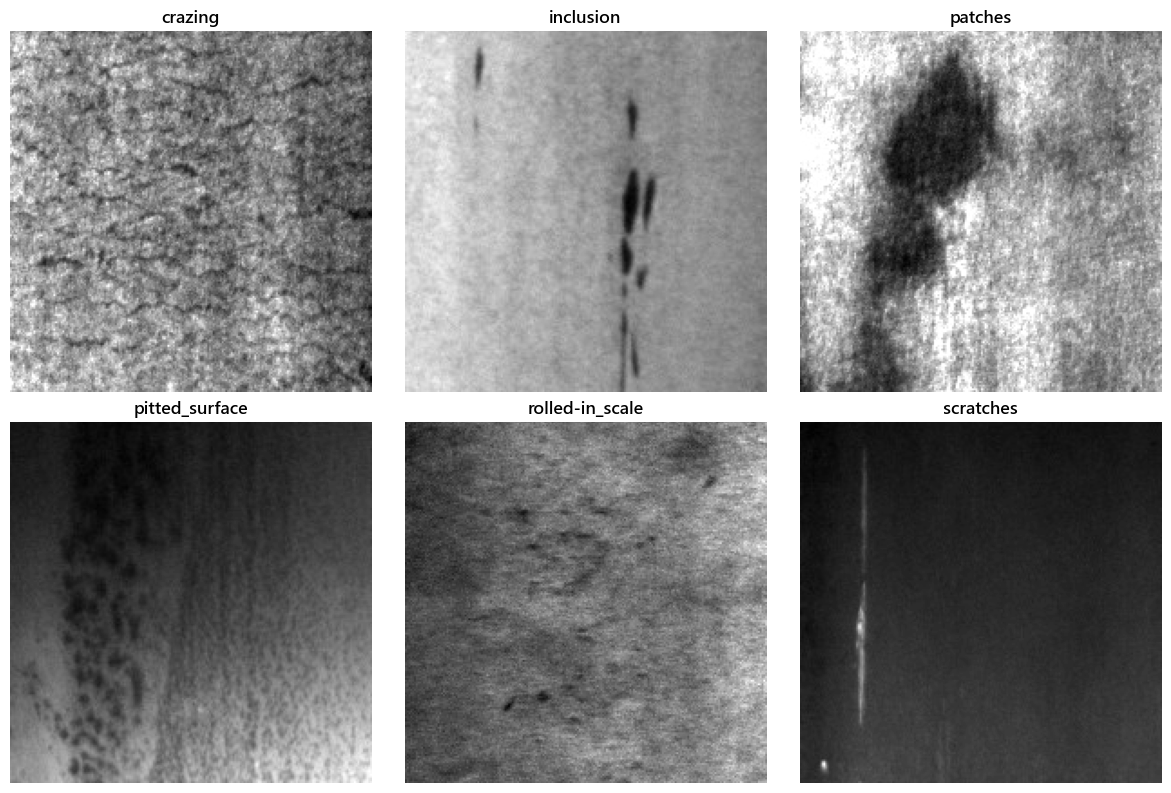

✓ 缺陷樣本可視化已儲存至: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_Results\defect_samples.png


In [3]:
# ===== 可視化每類缺陷的樣本 =====
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    class_dir = train_dir / class_name
    sample_path = list(class_dir.glob('*.jpg'))[0]  # 取第一張影像
    
    img = Image.open(sample_path).convert('L')  # 轉灰階
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"{class_name}", fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'defect_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 缺陷樣本可視化已儲存至:", RESULTS_DIR / 'defect_samples.png')

---
## 第 2 章：建立 Baseline（非深度學習方法）

在投入深度學習之前，先用傳統 ML 方法建立 baseline：
- **Random Forest**：集成樹模型，對影像像素特徵有基本辨識能力
- **MLP**：淺層神經網絡，檢驗是否需要深層 CNN

這一步的價值：
1. 快速驗證數據集是否有可學習的模式
2. 建立性能下限（CNN 應該要比這個好）
3. 如果 baseline 已經夠好，可以避免過度工程化

In [4]:
# ===== 載入影像並轉為扁平化特徵 =====
from sklearn.preprocessing import StandardScaler

def load_images_as_flattened(image_dir, class_names, img_size=(64, 64)):
    """
    載入影像並扁平化為向量（用於傳統 ML）
    
    Args:
        image_dir: 影像根目錄
        class_names: 類別名稱列表
        img_size: 調整後的影像尺寸 (減少計算量)
    
    Returns:
        X: 特徵矩陣 (n_samples, n_features)
        y: 標籤 (n_samples,)
    """
    X_list = []
    y_list = []
    
    for label, class_name in enumerate(class_names):
        class_dir = image_dir / class_name
        for img_path in class_dir.glob('*.jpg'):
            img = Image.open(img_path).convert('L')  # 灰階
            img = img.resize(img_size)  # 調整大小
            img_array = np.array(img).flatten()  # 扁平化
            
            X_list.append(img_array)
            y_list.append(label)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y

# 載入訓練集和驗證集
print("正在載入影像... (可能需要幾秒鐘)")
X_train_raw, y_train = load_images_as_flattened(train_dir, class_names)
X_val_raw, y_val = load_images_as_flattened(val_dir, class_names)

print(f"訓練集形狀: {X_train_raw.shape}, 標籤: {y_train.shape}")
print(f"驗證集形狀: {X_val_raw.shape}, 標籤: {y_val.shape}")

# 標準化（重要！ML 模型對特徵尺度敏感）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)

print("✓ 數據載入與標準化完成")

正在載入影像... (可能需要幾秒鐘)
訓練集形狀: (1440, 4096), 標籤: (1440,)
驗證集形狀: (360, 4096), 標籤: (360,)
✓ 數據載入與標準化完成


In [5]:
# ===== 訓練 Baseline 模型 =====
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

# 定義 baseline 模型
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'MLP': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True, 
                        validation_fraction=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"訓練 {name}...")
    print('='*60)
    
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 評估
    train_acc = model.score(X_train, y_train)
    val_acc = model.score(X_val, y_val)
    
    print(f"訓練時間: {train_time:.2f} 秒")
    print(f"訓練準確率: {train_acc:.4f}")
    print(f"驗證準確率: {val_acc:.4f}")
    
    # 儲存結果
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_time': train_time
    }

# 選擇最佳模型
best_model_name = max(results, key=lambda k: results[k]['val_acc'])
best_model = results[best_model_name]['model']
print(f"\n✓ 最佳 Baseline: {best_model_name} (驗證準確率: {results[best_model_name]['val_acc']:.4f})")


訓練 Random Forest...
訓練時間: 0.37 秒
訓練準確率: 0.9681
驗證準確率: 0.5917

訓練 MLP...
訓練時間: 5.13 秒
訓練準確率: 0.7465
驗證準確率: 0.3861

✓ 最佳 Baseline: Random Forest (驗證準確率: 0.5917)


---
## 第 3 章：混淆矩陣與錯誤分析

準確率只是一個數字，混淆矩陣才能告訴我們：
- 哪些類別容易被誤判？
- 是否有系統性的混淆（例如龜裂總是被誤判為劃痕）？
- 哪些錯誤在工業上可以接受，哪些完全不行？

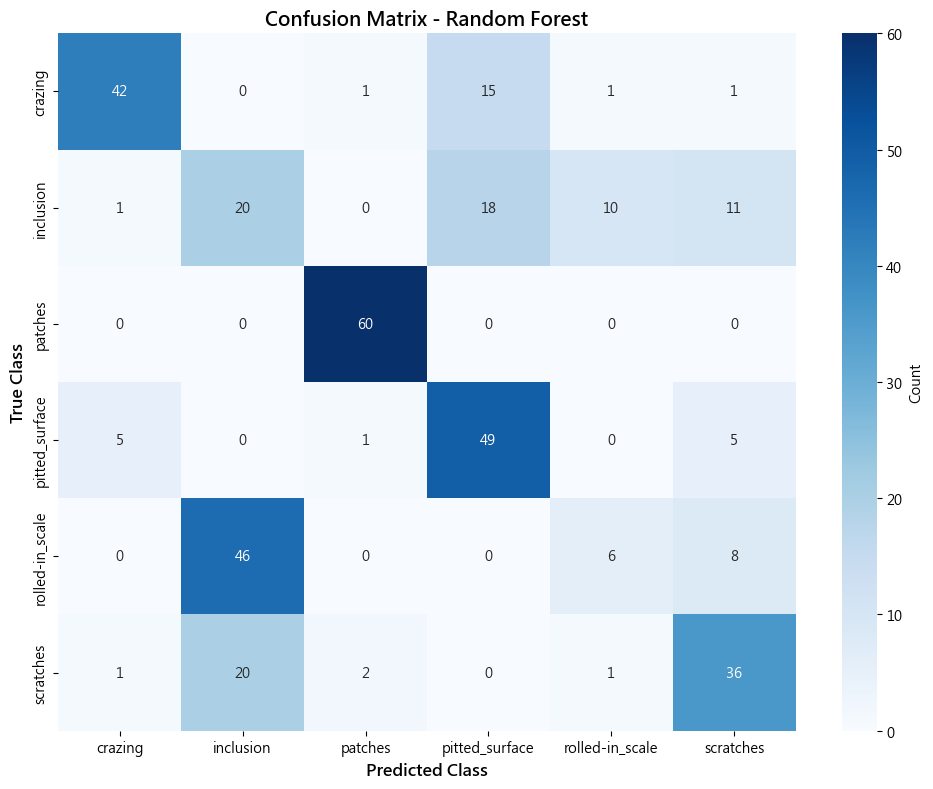

✓ 混淆矩陣已儲存至: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_Results\confusion_matrix.png

【分類報告】
              precision    recall  f1-score   support

          龜裂     0.8571    0.7000    0.7706        60
          雜質     0.2326    0.3333    0.2740        60
          斑塊     0.9375    1.0000    0.9677        60
          麻點     0.5976    0.8167    0.6901        60
         氧化皮     0.3333    0.1000    0.1538        60
          劃痕     0.5902    0.6000    0.5950        60

    accuracy                         0.5917       360
   macro avg     0.5914    0.5917    0.5752       360
weighted avg     0.5914    0.5917    0.5752       360



In [6]:
# ===== 混淆矩陣可視化 =====
import seaborn as sns

y_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

# 繪製混淆矩陣
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
ax.set_ylabel('True Class', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 混淆矩陣已儲存至:", RESULTS_DIR / 'confusion_matrix.png')

# 詳細分類報告
print("\n【分類報告】")
print("=" * 60)
print(classification_report(y_val, y_pred, target_names=class_names_zh, digits=4))

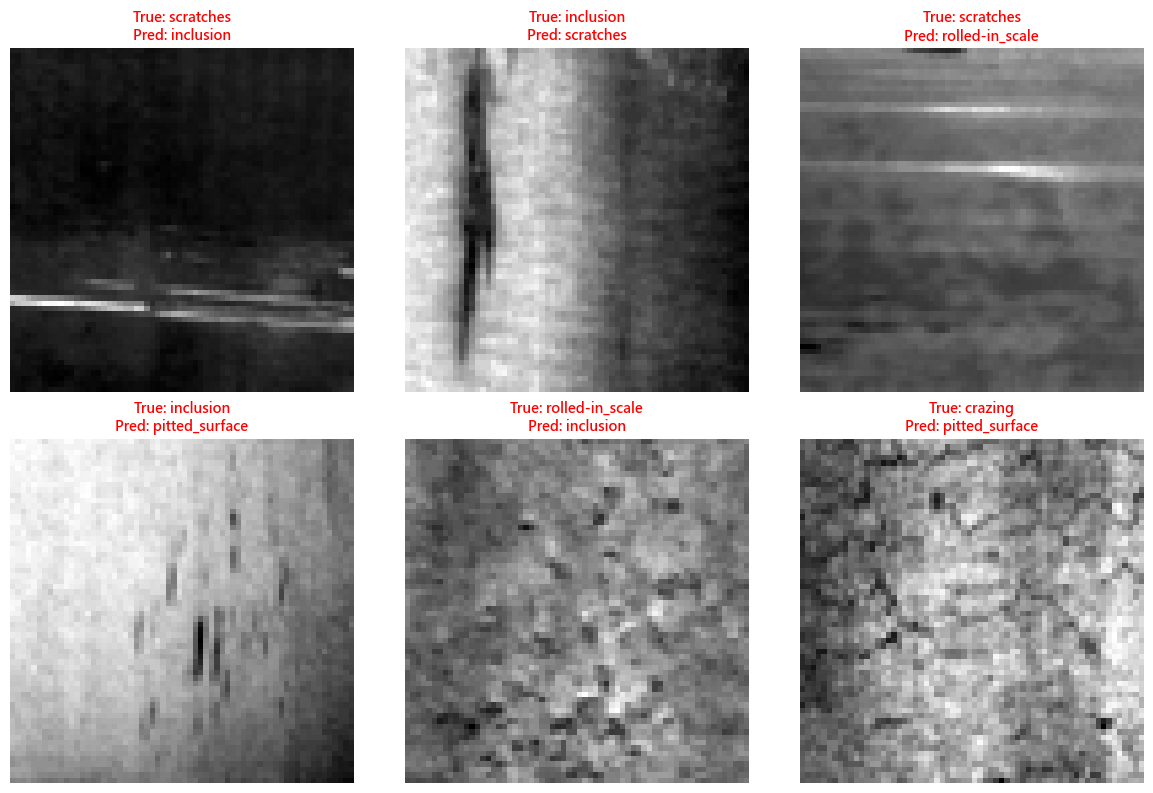

✓ 錯誤案例已儲存至: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_Results\error_cases.png


In [7]:
# ===== 錯誤案例可視化 =====
# 找出誤判的樣本
wrong_indices = np.where(y_pred != y_val)[0]

if len(wrong_indices) > 0:
    # 隨機選擇 6 個錯誤案例
    np.random.seed(42)
    sample_indices = np.random.choice(wrong_indices, min(6, len(wrong_indices)), replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for idx, sample_idx in enumerate(sample_indices):
        # 重建影像（從扁平化還原）
        img = X_val_raw[sample_idx].reshape(64, 64)
        
        true_label = class_names[y_val[sample_idx]]
        pred_label = class_names[y_pred[sample_idx]]
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"True: {true_label}\nPred: {pred_label}", 
                           fontsize=10, color='red', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'error_cases.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ 錯誤案例已儲存至:", RESULTS_DIR / 'error_cases.png')
else:
    print("⭐ 驚人！驗證集上沒有錯誤（這在真實數據上幾乎不可能）")

---
## 第 4 章：信心度門檻與拒絕選項（Reject Option）

在工業應用中，不是所有預測都應該被採納：
- **高信心預測**：直接放行或剔除
- **低信心預測**：送人工複檢

這樣可以減少災難性錯誤（例如漏報嚴重缺陷）。

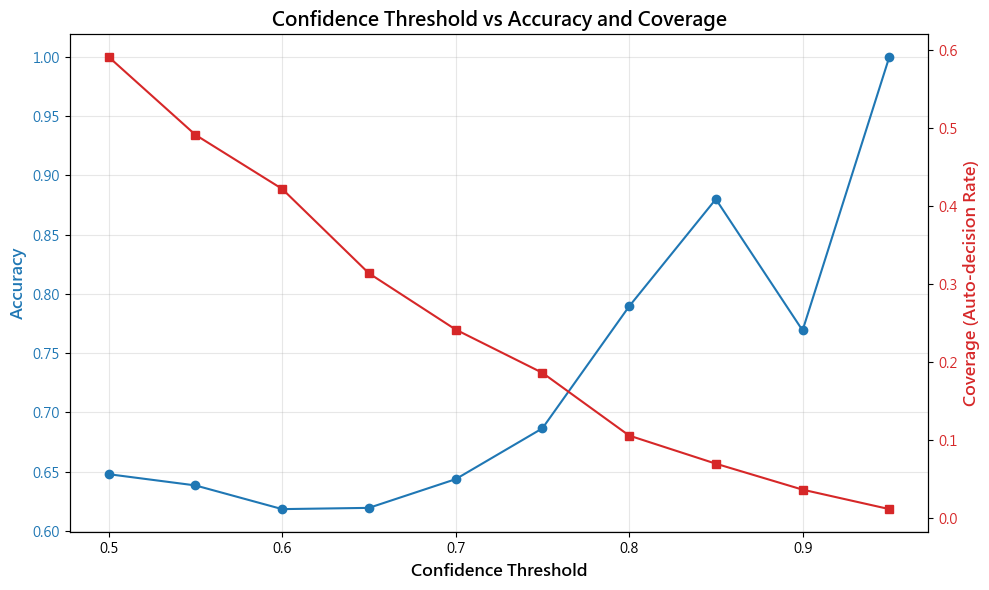

✓ 信心度權衡圖已儲存至: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_Results\confidence_tradeoff.png

推薦門檻: 0.95
  - 準確率: 1.0000
  - 覆蓋率: 0.0111 (需人工複檢: 98.89%)


In [8]:
# ===== 信心度分析 =====
# 獲取預測概率
y_proba = best_model.predict_proba(X_val)
y_confidence = np.max(y_proba, axis=1)  # 每個樣本的最高類別概率

# 分析不同信心度門檻下的性能
thresholds = np.arange(0.5, 1.0, 0.05)
metrics = []

for thr in thresholds:
    high_conf_mask = y_confidence >= thr
    
    if high_conf_mask.sum() > 0:
        acc = (y_pred[high_conf_mask] == y_val[high_conf_mask]).mean()
        coverage = high_conf_mask.mean()  # 覆蓋率（不需人工複檢的比例）
        
        metrics.append({
            'threshold': thr,
            'accuracy': acc,
            'coverage': coverage,
            'review_rate': 1 - coverage
        })

# 繪製 Accuracy-Coverage Tradeoff
import pandas as pd
df_metrics = pd.DataFrame(metrics)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Confidence Threshold', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', color=color, fontsize=12, fontweight='bold')
ax1.plot(df_metrics['threshold'], df_metrics['accuracy'], marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (Auto-decision Rate)', color=color, fontsize=12, fontweight='bold')
ax2.plot(df_metrics['threshold'], df_metrics['coverage'], marker='s', color=color, label='Coverage')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Confidence Threshold vs Accuracy and Coverage', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig(RESULTS_DIR / 'confidence_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 信心度權衡圖已儲存至:", RESULTS_DIR / 'confidence_tradeoff.png')

# 推薦門檻：準確率 > 95% 且覆蓋率盡可能高
recommended = df_metrics[df_metrics['accuracy'] >= 0.95].iloc[-1] if (df_metrics['accuracy'] >= 0.95).any() else df_metrics.iloc[0]
print(f"\n推薦門檻: {recommended['threshold']:.2f}")
print(f"  - 準確率: {recommended['accuracy']:.4f}")
print(f"  - 覆蓋率: {recommended['coverage']:.4f} (需人工複檢: {recommended['review_rate']:.2%})")

---
## 總結與下一步

### 你已經完成：
1. ✅ 理解工業影像檢測與 MNIST 的差異
2. ✅ 建立非深度學習 baseline（Random Forest / MLP）
3. ✅ 混淆矩陣分析與錯誤案例可視化
4. ✅ 信心度門檻設計（Reject Option）

### Baseline 性能總結：

In [9]:
# ===== 最終總結 =====
print("【Baseline 性能總結】")
print("=" * 60)
for name, res in results.items():
    print(f"{name}:")
    print(f"  訓練準確率: {res['train_acc']:.4f}")
    print(f"  驗證準確率: {res['val_acc']:.4f}")
    print(f"  訓練時間: {res['train_time']:.2f} 秒")
    print()

print("=" * 60)
print("【工業部署建議】")
print("=" * 60)
print("1. 如果 baseline 已經達到業務需求（例如 > 90% 且誤報可接受）")
print("   → 優先考慮部署簡單模型（Random Forest），而非追求 CNN")
print()
print("2. 如果 baseline 不足（例如混淆矩陣顯示系統性誤判）")
print("   → 考慮進階方法：CNN（Unit17 Transfer Learning）、數據增強、類別權重")
print()
print("3. 必須設計三段式決策流程：")
print("   - Pass：高信心正常 → 自動放行")
print("   - Review：低信心 → 人工複檢")
print("   - Fail：高信心缺陷 → 自動剔除")
print()
print("4. 定期監控模型性能（數據漂移檢測）")
print("   → 光照變化、新批次材料、設備更換都可能導致性能下降")
print("=" * 60)

【Baseline 性能總結】
Random Forest:
  訓練準確率: 0.9681
  驗證準確率: 0.5917
  訓練時間: 0.37 秒

MLP:
  訓練準確率: 0.7465
  驗證準確率: 0.3861
  訓練時間: 5.13 秒

【工業部署建議】
1. 如果 baseline 已經達到業務需求（例如 > 90% 且誤報可接受）
   → 優先考慮部署簡單模型（Random Forest），而非追求 CNN

2. 如果 baseline 不足（例如混淆矩陣顯示系統性誤判）
   → 考慮進階方法：CNN（Unit17 Transfer Learning）、數據增強、類別權重

3. 必須設計三段式決策流程：
   - Pass：高信心正常 → 自動放行
   - Review：低信心 → 人工複檢
   - Fail：高信心缺陷 → 自動剔除

4. 定期監控模型性能（數據漂移檢測）
   → 光照變化、新批次材料、設備更換都可能導致性能下降


---
## 選讀：Keras CNN 完整訓練流程

如果你的環境有 TensorFlow/Keras，可以繼續以下 CNN 訓練。

**為什麼可能需要 CNN？**
- Baseline 性能不足（< 85%）
- 混淆矩陣顯示需要更強的特徵學習能力
- 有足夠的計算資源和訓練時間

**注意事項：**
- 小數據集（< 2000 張）容易過擬合 → 必須用 Data Augmentation
- 訓練時間可能需要 10-30 分鐘（取決於硬體）

✓ TensorFlow 版本: 2.10.0
Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
               

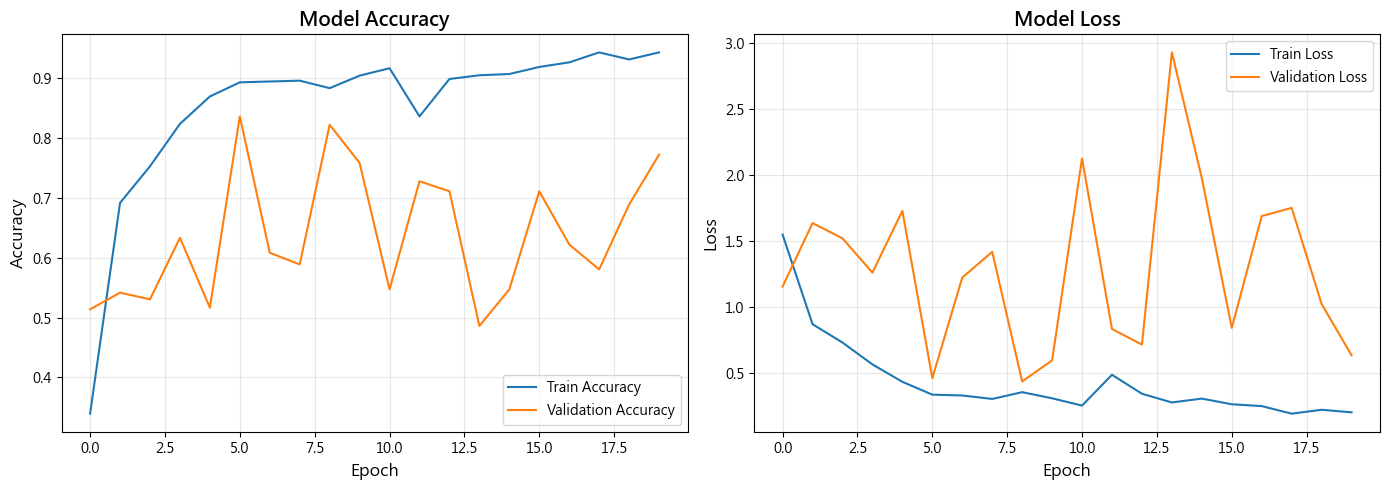

✓ CNN 訓練完成
最終驗證準確率: 0.7722


In [10]:
# ===== CNN 訓練（選讀）=====
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    print("✓ TensorFlow 版本:", tf.__version__)
    
    # 數據增強
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 數據生成器
    train_generator = train_datagen.flow_from_directory(
        str(train_dir),
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        color_mode='grayscale'
    )
    
    val_generator = val_datagen.flow_from_directory(
        str(val_dir),
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        color_mode='grayscale'
    )
    
    # 建立 CNN 模型
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    # 訓練（可能需要幾分鐘）
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        verbose=1
    )
    
    # 繪製學習曲線
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'cnn_learning_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ CNN 訓練完成")
    print(f"最終驗證準確率: {history.history['val_accuracy'][-1]:.4f}")
    
except ImportError:
    print("❌ TensorFlow 未安裝，跳過 CNN 訓練")
    print("如需安裝: pip install tensorflow")